In [4]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [61]:
class Game():
    '''
    board = 6x7 numpy array
    0 = empty
    1 = player 1 (yellow)
    2 = player 2 (red), computer

    '''

    def __init__(self):
        self.board = [
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
        ]
    
    def isValidMove(self, column:int) -> bool:
        # ToDo
        if self.board[0][column] == '-':
            return True
        else:
            return False

    def play(self, player:str, column:int):
        
        if not self.isValidMove(column=column):
            return 'invalid move!'
        
        column_values = [row[column] for row in game.board]
        row = max([i for i,v in enumerate(column_values) if v=='-']) # the row to which the chip will fall
        self.board[row][column] = player
        return 

    @staticmethod
    def plotBoard(board):
        mapping = {'-': 0, 'X': 1, 'O': 2}
        boardColors = []
        for row in game.board:
            boardColors.append([mapping[v] for v in row])

        # make a color map of fixed colors
        cmap = colors.ListedColormap(['gray', 'red', 'yellow'])
        bounds=[0,0.5,1.5,2]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        fig, ax = plt.subplots()
        c = ax.pcolor(boardColors, edgecolors='k', linewidths=4, cmap=cmap)
        ax.invert_yaxis()
        #ax.set_axis_off()
        ax.set_aspect('equal')
        return ax

    def checkWinner(self):

        pass


In [62]:
game = Game()

In [63]:
game.board

[['-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-']]

In [147]:
def does_square_contain_win(row, col, board):
    '''
    https://codereview.stackexchange.com/questions/112948/checking-for-a-win-in-connect-four
    (i,j)
    ---*--- ---*--- ---**** ---*---
    ----*-- --*---- ------- ---*---
    -----*- -*----- ------- ---*---
    ------* *------ ------- ---*---

    right_diag: [[i,j], [i-1,j+1], [i-2,j+2], [i-3,j+3]]
    left_diag: [[i,j], [i-1,j-1], [i-2,j-2], [i-3,j-3]]
    right: [[i,j], [i,j+1], [i,j+2], [i,j+3]]
    down: [[i,j], [i-1,j], [i-2,j], [i-3,j]]
    '''
    if board[row][col] == '-':
        return 
    print(row, col)
    
    # vertical down: 
    if row < len(board)-3:
        if (board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col]):
            return f'vertical win! - {board[row][col]}'
    
    # horizontal right:
    if col < len(board[0])-3:
        if (board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3]):
            return f'horizontal win! - {board[row][col]}'

    
    return 

   

def checkWin(board):
    for row in range(len(board)):
        for col in range(len(board[0])):
            result = does_square_contain_win(row, col, board)
            if result:
                print(result)

0 1
1 1
2 1
3 1
4 1
5 1


[]

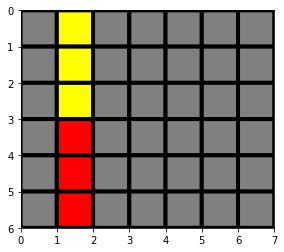

In [154]:
game = Game()


game.play(player='X', column=1)
game.play(player='X', column=1)
game.play(player='X', column=1)
game.play(player='O', column=1)
game.play(player='O', column=1)
game.play(player='O', column=1)

checkWin(game.board)


ax = game.plotBoard(game.board)
ax.plot()